In [41]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import selectors as cs
from sklearn.decomposition import IncrementalPCA

In [42]:
input_dir = "/home/vandy/Work/MATH6310/blunder-analysis/data/gold"
my_games = pl.scan_parquet(input_dir)

In [43]:
schema = my_games.collect_schema()

In [52]:
my_games.select(pl.len()).collect()

len
u32
12540813


In [44]:
important_columns = [
    "game_time",
    "increment",
    "turn",
    "cp_score",
    "winning_chance",
    "drawing_chance",
    "losing_chance",
    "piece_type",
    "is_check",
    "mate_in",
    # "clock",
    "eval_delta",
    "judgement",
    "time_control_type",
    "player_elo",
    "time_ratio",
    # "total_chance",
    # "fen_tensor",
]
important_columns = list(dict.fromkeys(important_columns))
raw_lazy = (
    my_games.select(important_columns)
    .with_columns(
        [
            cs.by_dtype(pl.Boolean).cast(pl.Int8),
            pl.when(pl.col("mate_in").is_infinite()).then(None).otherwise(pl.col("mate_in")).alias("mate_in"),
        ],
    )
    .with_columns(pl.col("mate_in").fill_null(0.0))
).filter(pl.col("time_ratio").is_finite())


In [45]:
from typing import cast


def get_enum_values(column):
    return cast("pl.Enum", schema.get(column)).categories


one_hot = (
    raw_lazy.with_columns(
        (pl.col("time_control_type") == value).cast(pl.Int8).alias(value)
        for value in get_enum_values("time_control_type")
    )
    .with_columns((pl.col("piece_type") == value).cast(pl.Int8).alias(value) for value in get_enum_values("piece_type"))
    .drop(["time_control_type", "piece_type"])
).drop("UNKNOWN")


In [46]:
target = one_hot.with_columns(
    pl.col("judgement").is_in(["Blunder", "Mistake", "Inaccuracy"]).cast(pl.Int8).alias("is_error"),
).drop("judgement").with_columns(pl.col("is_error").fill_null(0))

In [47]:
eval_scaled = target.with_columns(
    pl.when(pl.col("mate_in") == 0)
    .then((pl.col("cp_score") / 2019).tanh() * 0.99)
    .otherwise((pl.col("cp_score").sign()) * 1),
)

feature_columns = [
    col
    for col in eval_scaled.collect_schema().names()
    if col != "is_error"
]

scaled_features = (
    eval_scaled.with_columns(
        ((pl.col(col) - pl.mean(col)) / pl.std(col)).alias(col) for col in feature_columns
    ).select(feature_columns)
)

target_lazy = eval_scaled.select("is_error")

In [48]:
scaled_features.collect_schema()

Schema([('game_time', Float64),
        ('increment', Float64),
        ('turn', Float64),
        ('cp_score', Float64),
        ('winning_chance', Float64),
        ('drawing_chance', Float64),
        ('losing_chance', Float64),
        ('is_check', Float64),
        ('mate_in', Float64),
        ('eval_delta', Float64),
        ('player_elo', Float64),
        ('time_ratio', Float64),
        ('UNLIMITED', Float64),
        ('STANDARD', Float64),
        ('RAPID', Float64),
        ('BLITZ', Float64),
        ('BULLET', Float64),
        ('PAWN', Float64),
        ('KNIGHT', Float64),
        ('BISHOP', Float64),
        ('ROOK', Float64),
        ('QUEEN', Float64),
        ('KING', Float64)])

In [49]:
feature_sample = next(scaled_features.collect_batches(chunk_size=10))
target_sample = next(target_lazy.collect_batches(chunk_size=10))
feature_sample, target_sample

(shape: (10, 23)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬──────────┐
 │ game_time ┆ increment ┆ turn      ┆ cp_score  ┆ … ┆ BISHOP    ┆ ROOK     ┆ QUEEN     ┆ KING     │
 │ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---       ┆ ---      │
 │ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪══════════╡
 │ -0.204191 ┆ 0.890436  ┆ 0.992272  ┆ -0.016898 ┆ … ┆ -0.425015 ┆ -0.40234 ┆ -0.381391 ┆ -0.38148 │
 │ -0.204191 ┆ 0.890436  ┆ -1.007788 ┆ 0.012443  ┆ … ┆ -0.425015 ┆ -0.40234 ┆ -0.381391 ┆ -0.38148 │
 │ -0.204191 ┆ 0.890436  ┆ 0.992272  ┆ 0.005108  ┆ … ┆ -0.425015 ┆ -0.40234 ┆ -0.381391 ┆ -0.38148 │
 │ -0.204191 ┆ 0.890436  ┆ -1.007788 ┆ 0.008775  ┆ … ┆ -0.425015 ┆ -0.40234 ┆ -0.381391 ┆ -0.38148 │
 │ -0.204191 ┆ 0.890436  ┆ 0.992272  ┆ -0.002227 ┆ … ┆ 2.352857  ┆ -0.4023

In [50]:
ipca_components = 10
ipca = IncrementalPCA(n_components=ipca_components)


def iter_feature_batches():
    return scaled_features.collect_batches(chunk_size=10_000)


def iter_target_batches():
    return target_lazy.collect_batches(chunk_size=10_000)


for feature_batch in iter_feature_batches():
    ipca.partial_fit(feature_batch.to_numpy())

component_labels = [f"ipca_{i + 1}" for i in range(ipca_components)]
ipca_batches = []
for feature_batch, target_batch in zip(iter_feature_batches(), iter_target_batches()):
    transformed = ipca.transform(feature_batch.to_numpy())
    ipca_batch = pl.DataFrame(transformed, schema=component_labels).hstack(target_batch)
    ipca_batches.append(ipca_batch)

ipca_projection = pl.concat(ipca_batches, how="vertical").lazy()

ipca_summary = pl.DataFrame(
    {
        "component": component_labels,
        "explained_variance_ratio": ipca.explained_variance_ratio_,
    },
)
print(ipca_summary)

shape: (10, 2)
┌───────────┬──────────────────────────┐
│ component ┆ explained_variance_ratio │
│ ---       ┆ ---                      │
│ str       ┆ f64                      │
╞═══════════╪══════════════════════════╡
│ ipca_1    ┆ 0.107285                 │
│ ipca_2    ┆ 0.082896                 │
│ ipca_3    ┆ 0.075538                 │
│ ipca_4    ┆ 0.057192                 │
│ ipca_5    ┆ 0.056555                 │
│ ipca_6    ┆ 0.055003                 │
│ ipca_7    ┆ 0.051861                 │
│ ipca_8    ┆ 0.050164                 │
│ ipca_9    ┆ 0.043533                 │
│ ipca_10   ┆ 0.04303                  │
└───────────┴──────────────────────────┘


/tmp/ipykernel_146798/2906860284.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("coolwarm", 2)
/tmp/ipykernel_146798/2906860284.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_146798/2906860284.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/vandy/Work/MATH6310/blunder-analysis/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/vandy/Work/MATH6310/blunder-analysis/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  

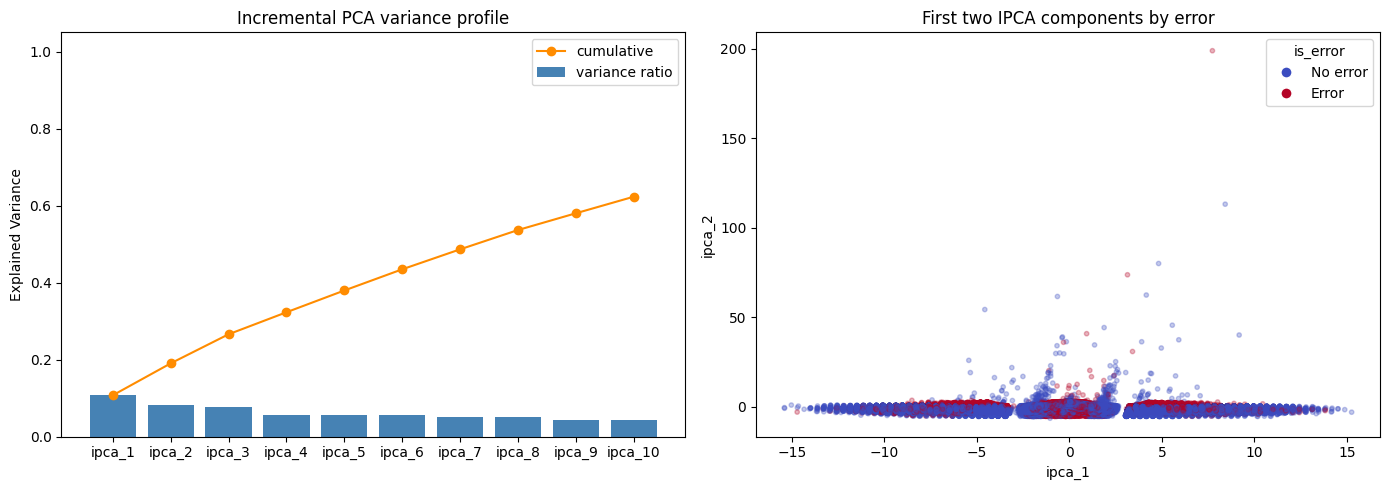

In [51]:
component_cumsum = np.cumsum(ipca.explained_variance_ratio_)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(component_labels, ipca.explained_variance_ratio_, color="steelblue", label="variance ratio")
axes[0].plot(component_labels, component_cumsum, marker="o", color="darkorange", label="cumulative")
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel("Explained Variance")
axes[0].set_title("Incremental PCA variance profile")
axes[0].legend()
projection_df = ipca_projection.collect()
if len(component_labels) >= 2:
    cmap = plt.cm.get_cmap("coolwarm", 2)
    scatter = axes[1].scatter(
        projection_df.get_column(component_labels[0]),
        projection_df.get_column(component_labels[1]),
        c=projection_df.get_column("is_error"),
        cmap=cmap,
        s=10,
        alpha=0.3,
    )
    axes[1].set_xlabel(component_labels[0])
    axes[1].set_ylabel(component_labels[1])
    axes[1].set_title("First two IPCA components by error")
    legend_handles = [
        plt.Line2D([], [], marker="o", color="w", markerfacecolor=cmap(0), label="No error", markersize=8),
        plt.Line2D([], [], marker="o", color="w", markerfacecolor=cmap(1), label="Error", markersize=8),
    ]
    axes[1].legend(handles=legend_handles, title="is_error")
else:
    axes[1].axis("off")
plt.tight_layout()